In [70]:
# Imports and small helpers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import hdbscan

plt.rcParams["figure.figsize"] = (6.5, 5)
plt.rcParams["axes.grid"] = True

def scatter(X, labels, title, cmap="tab10"):
    plt.figure()
    # noise points in gray (-1), clusters colored by label
    is_noise = (labels == -1)
    if np.any(is_noise):
        plt.scatter(X[is_noise,0], X[is_noise,1], c="lightgray", s=18, label="noise (-1)")
    for lab in sorted(set(labels) - {-1}):
        sel = (labels == lab)
        plt.scatter(X[sel,0], X[sel,1], s=28, label=f"cluster {lab}")
    plt.xlabel("Feature 1"); plt.ylabel("Feature 2"); plt.title(title)
    if len(set(labels)) > 1: plt.legend(loc="best", fontsize=9, frameon=True)
    plt.tight_layout(); plt.show()

Data source: Mall Customers, shape: (200, 2)


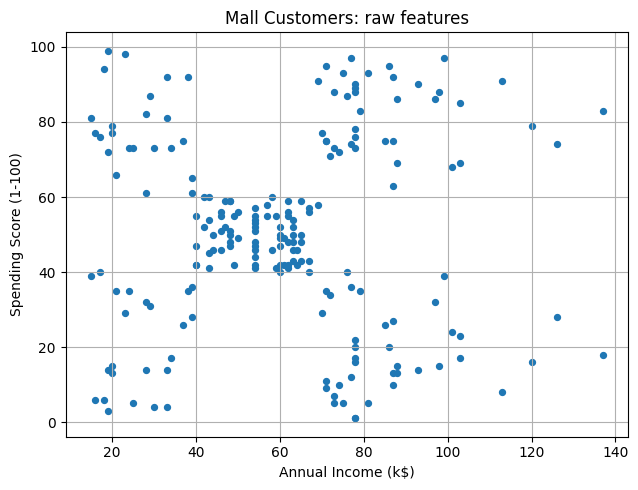

In [71]:
# Load two intuitive features
CSV_PATH = "datasets/Mall_Customers.csv"

df = pd.read_csv(CSV_PATH)
X_df = df[['Annual Income (k$)', 'Spending Score (1-100)']].copy()
source = "Mall Customers"

X = X_df.values
print(f"Data source: {source}, shape: {X.shape}")
plt.figure(); plt.scatter(X[:,0], X[:,1], s=18)
plt.title(f"{source}: raw features"); plt.xlabel(X_df.columns[0]); plt.ylabel(X_df.columns[1])
plt.tight_layout(); plt.show()


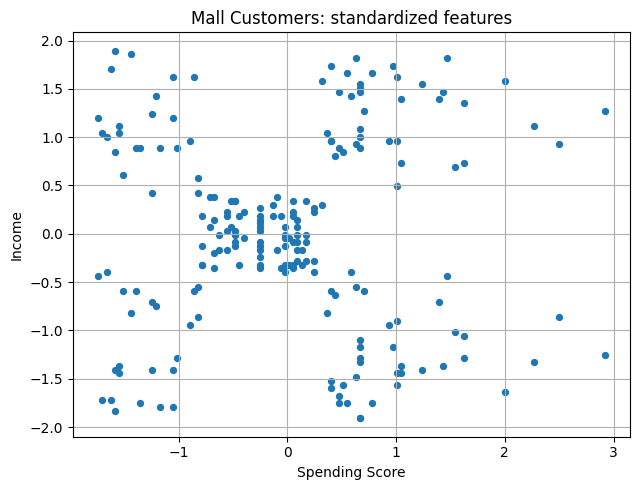

In [72]:
# Standardize so both axes contribute fairly to distance
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

plt.figure(); plt.scatter(Xs[:,0], Xs[:,1], s=18)
plt.title(f"{source}: standardized features"); plt.xlabel("Spending Score"); plt.ylabel("Income")
plt.tight_layout(); plt.show()


Clusters found: 5
Noise rate: 18.00%


/Users/kelvin/HDBSCAN_Youtube/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/kelvin/HDBSCAN_Youtube/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


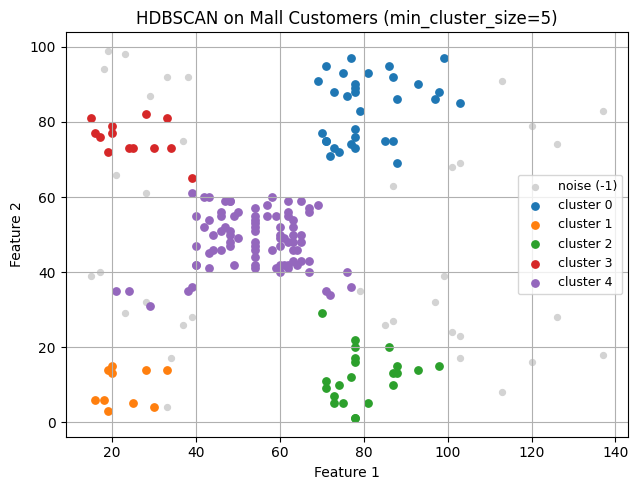

In [73]:
# Fit HDBSCAN with sensible starting values
clusterer = hdbscan.HDBSCAN(min_cluster_size=5,      # try 10–50 depending on dataset size
                            min_samples=None,         # None -> defaults to min_cluster_size; set e.g. 10 for more conservatism
                            metric='euclidean',
                            cluster_selection_method='eom',  # 'eom' = excess of mass (default); 'leaf' for finer clusters
                            prediction_data=True,     # enables soft assignments later
                            core_dist_n_jobs=1,       # set >1 if you want parallelism
                            )

labels = clusterer.fit_predict(Xs)
n_clusters = len(set(labels) - {-1})
noise_rate = np.mean(labels == -1)

print(f"Clusters found: {n_clusters}")
print(f"Noise rate: {noise_rate:.2%}")
scatter(X, labels, title=f"HDBSCAN on {source} (min_cluster_size=5)")


Membership strength range: 0.0 to 1.0


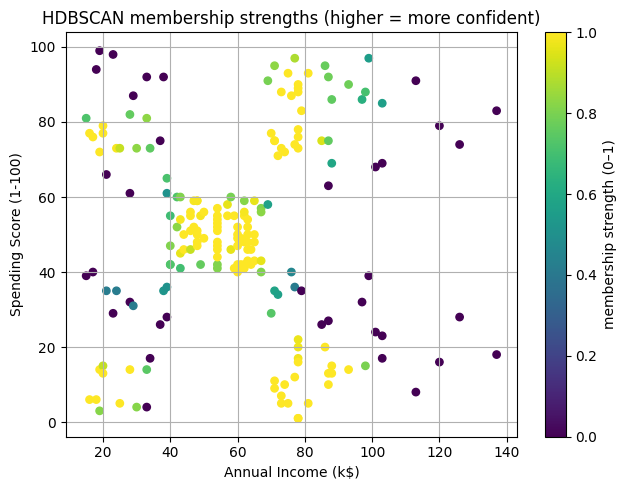

In [74]:
# Membership strength (soft clustering): how confidently each point belongs to its assigned cluster
probs = clusterer.probabilities_
print("Membership strength range:", probs.min(), "to", probs.max())

plt.figure()
plt.scatter(X[:,0], X[:,1], c=probs, s=28, cmap="viridis")
plt.colorbar(label="membership strength (0–1)")
plt.title("HDBSCAN membership strengths (higher = more confident)")
plt.xlabel(X_df.columns[0]); plt.ylabel(X_df.columns[1])
plt.tight_layout(); plt.show()


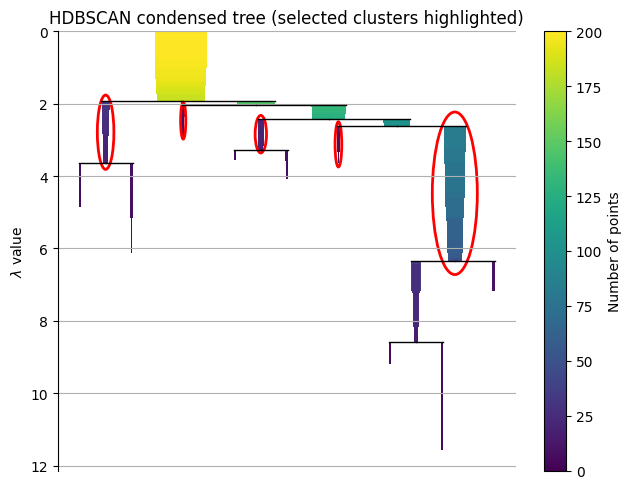

In [75]:
# Condensed tree: visualize the density hierarchy and see where clusters are born/merge
# (Works best with ~thousands or fewer points in a demo.)
_ = clusterer.condensed_tree_.plot(select_clusters=True)
plt.title("HDBSCAN condensed tree (selected clusters highlighted)")
plt.tight_layout(); plt.show()


In [76]:
import warnings

warnings.filterwarnings(
    "ignore",
    message=".*'force_all_finite' was renamed to 'ensure_all_finite'.*",
    category=FutureWarning,
    module=r"sklearn\.utils\.deprecation"
)

# Quick parameter sweep to build intuition (small grid)
def run_hdbscan(min_cluster_size, min_samples=None):
    cl = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                         min_samples=min_samples,
                         metric="euclidean",
                         cluster_selection_method="eom",
                         prediction_data=False
    )
    labs = cl.fit_predict(Xs)
    ncl = len(set(labs) - {-1})
    noise = np.mean(labs == -1)
    return ncl, noise

grid = []
for mcs in [10, 20, 30, 40]:
    for ms in [None, 5, 10, 15]:
        ncl, noise = run_hdbscan(mcs, ms)
        grid.append((mcs, ms, ncl, noise))

pd.DataFrame(grid, columns=["min_cluster_size", "min_samples", "#clusters", "noise_rate"])


,min_cluster_size,min_samples,#clusters,noise_rate
0,10,NaN,3,0.315
1,10,5.0,5,0.180
2,10,10.0,3,0.315
3,10,15.0,2,0.420
4,20,NaN,0,1.000
5,20,5.0,3,0.215
6,20,10.0,3,0.315
7,20,15.0,0,1.000
8,30,NaN,0,1.000
9,30,5.0,2,0.090


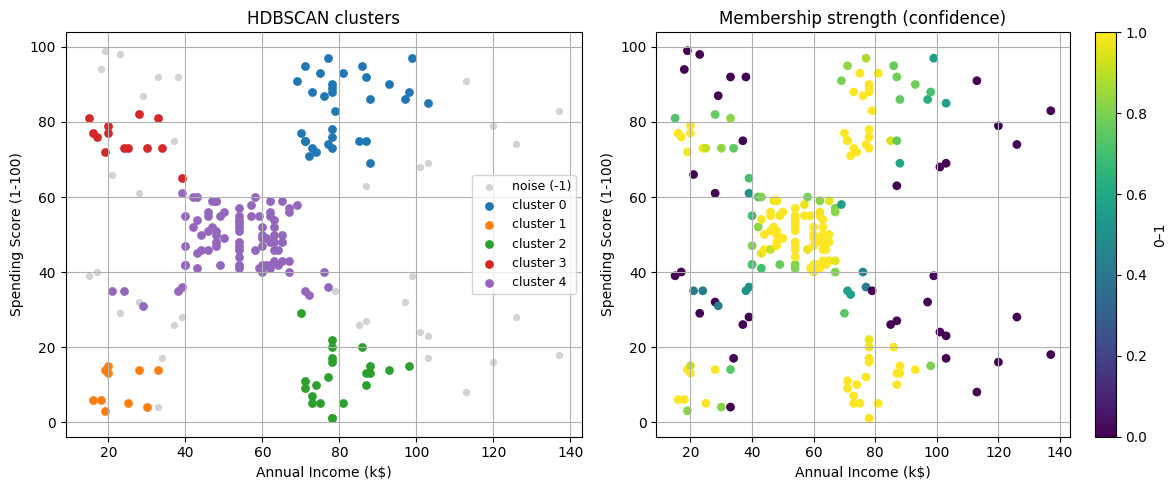

In [77]:
# Final visualization: side-by-side labels vs membership strength (simple sequentially)
fig, ax = plt.subplots(1, 2, figsize=(12,5))
# labels
is_noise = (labels == -1)
ax[0].scatter(X[is_noise,0], X[is_noise,1], c="lightgray", s=18, label="noise (-1)")
for lab in sorted(set(labels) - {-1}):
    sel = (labels == lab)
    ax[0].scatter(X[sel,0], X[sel,1], s=28, label=f"cluster {lab}")
ax[0].set_title("HDBSCAN clusters"); ax[0].set_xlabel(X_df.columns[0]); ax[0].set_ylabel(X_df.columns[1])
ax[0].legend(loc="best", fontsize=9, frameon=True)

# membership strength
p = ax[1].scatter(X[:,0], X[:,1], c=probs, s=28, cmap="viridis")
ax[1].set_title("Membership strength (confidence)"); ax[1].set_xlabel(X_df.columns[0]); ax[1].set_ylabel(X_df.columns[1])
fig.colorbar(p, ax=ax[1], label="0–1")
plt.tight_layout(); plt.show()
